# Requirement 3 - Sentiment Analysis

In [498]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
from tensorflow import keras as keras
import numpy as np
import pandas as pd
import warnings
from matplotlib import pyplot as plt
from timeit import default_timer as timer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS, HashingVectorizer, TfidfVectorizer
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import RidgeClassifier, PassiveAggressiveClassifier, SGDClassifier
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from sklearn.decomposition import TruncatedSVD
from sklearn.svm import LinearSVC
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)
%matplotlib inline

In [499]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

/home/dimitriosrou/anaconda3/envs/ml_gpu/lib/python3.6/site-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [500]:
np.random.seed(42)
tf.random.set_seed(22)

In [501]:
warnings.simplefilter(action='ignore', category=FutureWarning)

In [502]:
df = pd.read_csv('train.csv')

In [503]:
df.head()

,Content,Label,Id
0,Whoever made this movie must have done it as a...,0,0
1,I love this movie because I grew up around har...,1,1
2,"I had some expectation for the movie, since it...",0,2
3,"During the early 1980's, Kurt Thomas was somet...",0,3
4,Poor Will would be rolling over in his grave i...,0,4


In [506]:
df.info()
len_start = len(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 3 columns):
Content    25000 non-null object
Label      25000 non-null int64
Id         25000 non-null int64
dtypes: int64(2), object(1)
memory usage: 586.1+ KB


In [507]:
# Remove articles with duplicate content

df.drop_duplicates(subset='Content', keep='last', inplace=True)

In [508]:
df.info()
len_end = len(df)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24904 entries, 0 to 24999
Data columns (total 3 columns):
Content    24904 non-null object
Label      24904 non-null int64
Id         24904 non-null int64
dtypes: int64(2), object(1)
memory usage: 778.2+ KB


In [509]:
# Display number of duplicates in the dataset

print('{} duplicate articles were removed from the dataset'
      .format(len_start - len_end))

96 duplicate articles were removed from the dataset


In [510]:
# Relative frequency of labels

rel_freq = df.groupby('Label').Content.count() / len(df)
print(rel_freq)

Label
0    0.499197
1    0.500803
Name: Content, dtype: float64


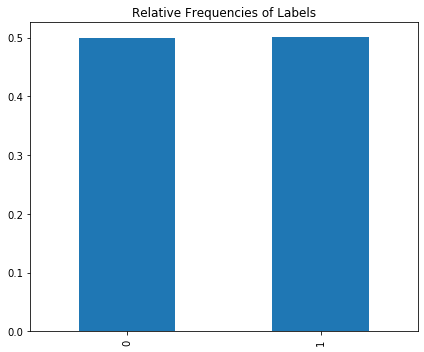

In [511]:
fig, ax = plt.subplots(figsize=(6, 5))
rel_freq.plot.bar(ax=ax)
ax.set_title('Relative Frequencies of Labels')
ax.set_xlabel('')
fig.tight_layout()
plt.savefig('label_freq.png')
plt.show()

In [512]:
def get_metrics(y_true, y_pred, metrics):
    metrics[0] += accuracy_score(y_true, y_pred)
    metrics[1] += precision_score(y_true, y_pred, average='macro')
    metrics[2] += recall_score(y_true, y_pred, average='macro')
    metrics[3] += f1_score(y_true, y_pred, average='macro')
    return metrics

In [513]:
def evaluate_classifier(clf, kfold, X, y, vectorizer, svd_enable=False):
    metrics = np.zeros(4)
    if svd_enable:
        svd = TruncatedSVD(n_components=300)
    start = timer()
    for train, cv in kfold.split(X, y):
        X_train, X_cv = X[train], X[cv]
        y_train, y_cv = y[train], y[cv]
        X_train_gen = [x for x in X_train]
        vectorizer.fit(X_train_gen)
        X_train_vec = vectorizer.transform(X_train_gen)
        if svd_enable:
            svd.fit(X_train_vec, y_train)
            X_train_vec = svd.transform(X_train_vec)
        clf.fit(X_train_vec, y_train)
        X_cv_gen = [x for x in X_cv]
        X_cv_vec = vectorizer.transform(X_cv_gen)
        if svd_enable:
            X_cv_vec = svd.transform(X_cv_vec)
        y_pred = clf.predict(X_cv_vec)
        metrics = get_metrics(y_cv, y_pred, metrics)
    dt = timer() - start
    metrics = metrics * 100 / 5
    print('Evaluation of classifier finished in {:.2f} s \n'
          'Average accuracy: {:.2f} % \n'
          'Average precision: {:.2f} % \n'
          'Average recall: {:.2f} % \n'
          'Average f-measure: {:.2f} % \n'
          .format(dt, metrics[0], metrics[1],
                  metrics[2], metrics[3]))

## Classic machine learning method

In [520]:
# 5-Fold cross-validation

kf = KFold(n_splits=5, shuffle=True, random_state=56)

# TF-IDF vectorizer and stop words

stop_words = ENGLISH_STOP_WORDS
tfidf = TfidfVectorizer(stop_words=stop_words, min_df=2, 
                        max_df=0.45, ngram_range=(1, 2))

# SVM

svm = LinearSVC()

In [521]:
X = df['Content'].to_dense().values
y = df['Label'].to_dense().values

In [522]:
# SVM - BoW

evaluate_classifier(svm, kf, X, y, tfidf)

Evaluation of classifier finished in 108.43 s 
Average accuracy: 89.69 % 
Average precision: 89.71 % 
Average recall: 89.69 % 
Average f-measure: 89.69 % 



## Deep neural network method

In [571]:
def evaluate_neural_net(kfold, X, y, vectorizer):
    i = 1
    metrics = np.zeros(4)
    start = timer()
    for train, cv in kfold.split(X, y):
        X_train, X_cv = X[train], X[cv]
        y_train, y_cv = y[train], y[cv]
        vectorizer.fit(X_train)
        X_train_vec = vectorizer.transform(X_train)
        input_shape = X_train_vec.shape[1:]
        model, early_stopping, model_checkpoint = build_model(input_shape, i)
        history = model.fit(X_train_vec, y_train,
                            batch_size=256, epochs=80, 
                            callbacks=[early_stopping, 
                                       model_checkpoint],
                            verbose=1, validation_split=0.10)
        final_model = keras.models.load_model('imdb_sentiment_{}.h5'.format(i))
        X_cv_vec = vectorizer.transform(X_cv)
        prediction = final_model.predict(X_cv_vec)
        y_pred = (prediction > 0.5)
        y_pred = y_pred * 1
        metrics = get_metrics(y_cv, y_pred, metrics)
        i += 1
    dt = timer() - start
    metrics = metrics * 100 / 5
    print('Evaluation of classifier finished in {:.2f} s \n'
          'Average accuracy: {:.2f} % \n'
          'Average precision: {:.2f} % \n'
          'Average recall: {:.2f} % \n'
          'Average f-measure: {:.2f} % \n'
          .format(dt, metrics[0], metrics[1],
                  metrics[2], metrics[3]))
    
    return history

In [572]:
def build_model(input_shape, i):
    
    keras.backend.clear_session()
    model = keras.Sequential([
        keras.layers.Dropout(0.25, input_shape=input_shape),
        keras.layers.Dense(96, activation='relu'),
        keras.layers.Dropout(0.9),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dropout(0.85),
        keras.layers.Dense(1, activation='sigmoid')
    ])

    early_stopping = keras.callbacks.EarlyStopping(patience=3)
    model_checkpoint = keras.callbacks.ModelCheckpoint(
                       'imdb_sentiment_{}.h5'.format(i), save_best_only=True)
    optimizer = keras.optimizers.Adam(lr=0.005, amsgrad=True)
    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model, early_stopping, model_checkpoint

In [573]:
X = df['Content'].values
y = df['Label'].values

In [574]:
# 5-Fold cross-validation

kf = KFold(n_splits=5, shuffle=True, random_state=56)

# TF-IDF vectorizer and stop words

stop_words = ENGLISH_STOP_WORDS
tfidf = TfidfVectorizer(stop_words=stop_words, min_df=2, 
                        max_df=0.45, ngram_range=(1, 2))

In [575]:
history = evaluate_neural_net(kf, X, y, tfidf)

Train on 17930 samples, validate on 1993 samples
Epoch 1/80
17930/17930 [==============================] - 33s 2ms/sample - loss: 0.6476 - accuracy: 0.5909 - val_loss: 0.4629 - val_accuracy: 0.8545
Epoch 2/80
17930/17930 [==============================] - 26s 1ms/sample - loss: 0.5300 - accuracy: 0.7279 - val_loss: 0.3799 - val_accuracy: 0.8796
Epoch 3/80
17930/17930 [==============================] - 26s 1ms/sample - loss: 0.4565 - accuracy: 0.7800 - val_loss: 0.3257 - val_accuracy: 0.8826
Epoch 4/80
17930/17930 [==============================] - 25s 1ms/sample - loss: 0.4228 - accuracy: 0.8083 - val_loss: 0.3194 - val_accuracy: 0.8881
Epoch 5/80
17930/17930 [==============================] - 25s 1ms/sample - loss: 0.3899 - accuracy: 0.8200 - val_loss: 0.2893 - val_accuracy: 0.8861
Epoch 6/80
17930/17930 [==============================] - 24s 1ms/sample - loss: 0.3627 - accuracy: 0.8404 - val_loss: 0.2820 - val_accuracy: 0.8871
Epoch 7/80
17930/17930 [==============================] -

17930/17930 [==============================] - 22s 1ms/sample - loss: 0.4113 - accuracy: 0.8139 - val_loss: 0.2927 - val_accuracy: 0.8921
Epoch 5/80
17930/17930 [==============================] - 24s 1ms/sample - loss: 0.3755 - accuracy: 0.8288 - val_loss: 0.2900 - val_accuracy: 0.8916
Epoch 6/80
17930/17930 [==============================] - 24s 1ms/sample - loss: 0.3473 - accuracy: 0.8448 - val_loss: 0.2729 - val_accuracy: 0.9027
Epoch 7/80
17930/17930 [==============================] - 24s 1ms/sample - loss: 0.3346 - accuracy: 0.8511 - val_loss: 0.2627 - val_accuracy: 0.9027
Epoch 8/80
17930/17930 [==============================] - 22s 1ms/sample - loss: 0.3144 - accuracy: 0.8599 - val_loss: 0.2638 - val_accuracy: 0.8951
Epoch 9/80
17930/17930 [==============================] - 23s 1ms/sample - loss: 0.2874 - accuracy: 0.8715 - val_loss: 0.2547 - val_accuracy: 0.9042
Epoch 10/80
17930/17930 [==============================] - 21s 1ms/sample - loss: 0.2793 - accuracy: 0.8723 - val_los

In [576]:
# Evaluate train and validation accuracies and losses

train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Visualize epochs vs. train and validation accuracies and losses

plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend()
plt.title('Epochs vs. Training and Validation Accuracy')
    
plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend()
plt.title('Epochs vs. Training and Validation Loss')

plt.show()

NameError: name 'history' is not defined

In [580]:
# Visualize the architecture of the model

model = build_model(input_shape, 1)
keras.utils.plot_model(model, to_file='model_plot.png', show_shapes=True, 
                       show_layer_names=True, rankdir='LR')

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


## Deliverable for competition

In [53]:
df_test = pd.read_csv('test_without_labels.csv')

In [54]:
X_final = df_test['Content'].values

In [61]:
tfidf.fit(X)
X_train_vec = tfidf.transform(X)
input_shape = X_train_vec.shape[1:]

keras.backend.clear_session()

model = keras.Sequential([
    keras.layers.Dropout(0.25, input_shape=input_shape),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.9),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.85),
    keras.layers.Dense(1, activation='sigmoid')
])

early_stopping = keras.callbacks.EarlyStopping(patience=5)
model_checkpoint = keras.callbacks.ModelCheckpoint(
                   "imdb_sentiment.h5", save_best_only=True)
reduce_lr = keras.callbacks.ReduceLROnPlateau(factor=0.7, patience=3)
optimizer = keras.optimizers.Adam(lr=1e-2, amsgrad=True)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [62]:
model.fit(X_train_vec, y,
          batch_size=256, epochs=80, 
          callbacks=[early_stopping, 
                     model_checkpoint,
                     reduce_lr],
          validation_split=0.20)

Train on 21250 samples, validate on 3750 samples
Epoch 1/80
21250/21250 [==============================] - 24s 1ms/sample - loss: 0.6268 - accuracy: 0.6173 - val_loss: 0.4106 - val_accuracy: 0.8736
Epoch 2/80
21250/21250 [==============================] - 19s 879us/sample - loss: 0.4924 - accuracy: 0.7607 - val_loss: 0.3294 - val_accuracy: 0.8901
Epoch 3/80
21250/21250 [==============================] - 19s 884us/sample - loss: 0.4349 - accuracy: 0.8056 - val_loss: 0.3001 - val_accuracy: 0.8987
Epoch 4/80
21250/21250 [==============================] - 19s 872us/sample - loss: 0.3815 - accuracy: 0.8316 - val_loss: 0.2712 - val_accuracy: 0.9003
Epoch 5/80
21250/21250 [==============================] - 19s 875us/sample - loss: 0.3635 - accuracy: 0.8457 - val_loss: 0.2644 - val_accuracy: 0.9003
Epoch 6/80
21250/21250 [==============================] - 19s 874us/sample - loss: 0.3236 - accuracy: 0.8606 - val_loss: 0.2508 - val_accuracy: 0.9037
Epoch 7/80
21250/21250 [=======================

In [75]:
X_test_vec = tfidf.transform(X_final)
final_model = keras.models.load_model('imdb_sentiment.h5')
prediction = final_model.predict(X_test_vec)
y_pred = (prediction > 0.5)

In [76]:
y_pred = y_pred * 1

In [77]:
df_results = pd.DataFrame({'Id':df_test['Id'], 'Predicted':y_pred[:, 0]})

In [78]:
df_results.to_csv('sentiment_predictions.csv',index=False, header=True)

## Proposed method

In [413]:
X_enh = df['Content'].to_dense().values
y_enh = df['Label'].to_dense().values

In [414]:
X_train_cv, X_test, y_train_cv, y_test = train_test_split(X, y, test_size=0.20, shuffle=True)

In [456]:
svm = LinearSVC(C=0.85, tol=1e-05, max_iter=1500)
ridge = RidgeClassifier(alpha=1.1, tol=1e-5, normalize=True)
ridge_2 = RidgeClassifier(alpha=1.1, tol=1e-5)
ridge_3 = RidgeClassifier(alpha=1.15, tol=1e-5)
pas_agr = PassiveAggressiveClassifier(C=0.85, early_stopping=True, tol=1e-5,
                                      loss='squared_hinge', n_jobs=-1)
pas_agr_2 = PassiveAggressiveClassifier(C=0.8, early_stopping=True, tol=1e-5,
                                        loss='squared_hinge', n_jobs=-1)
pas_agr_3 = PassiveAggressiveClassifier(C=0.75, early_stopping=True, tol=1e-5,
                                        loss='squared_hinge', n_jobs=-1)
sgd = SGDClassifier(early_stopping=True, tol=1e-5, max_iter=1500,
                    loss='modified_huber', penalty='elasticnet',
                    l1_ratio=0.05, n_jobs=-1)
sgd_2 = SGDClassifier(early_stopping=True, tol=1e-5, max_iter=1500,
                    loss='modified_huber', penalty='elasticnet',
                    l1_ratio=0.1, n_jobs=-1)

In [440]:
tfidf_1 = TfidfVectorizer(stop_words=stop_words, min_df=2, 
                          max_df=0.6, ngram_range=(1, 3))

In [441]:
evaluate_classifier(svm, kf, X, y, tfidf_1)

Evaluation of classifier finished in 92.81 s 
Average accuracy: 89.35 % 
Average precision: 89.37 % 
Average recall: 89.35 % 
Average f-measure: 89.35 % 



In [442]:
evaluate_classifier(ridge, kf, X, y, tfidf_1)

/home/dimitriosrou/anaconda3/envs/ml_gpu/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/dimitriosrou/anaconda3/envs/ml_gpu/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/dimitriosrou/anaconda3/envs/ml_gpu/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Evaluation of classifier finished in 204.99 s 
Average accuracy: 88.88 % 
Average precision: 88.89 % 
Average recall: 88.88 % 
Average f-measure: 88.88 % 



In [443]:
evaluate_classifier(ridge_2, kf, X, y, tfidf_1)

Evaluation of classifier finished in 95.50 s 
Average accuracy: 89.32 % 
Average precision: 89.35 % 
Average recall: 89.32 % 
Average f-measure: 89.32 % 



In [490]:
evaluate_classifier(ridge_3, kf, X, y, tfidf_1)

Evaluation of classifier finished in 100.75 s 
Average accuracy: 89.34 % 
Average precision: 89.37 % 
Average recall: 89.34 % 
Average f-measure: 89.34 % 



In [444]:
evaluate_classifier(pas_agr, kf, X, y, tfidf_1)

Evaluation of classifier finished in 90.54 s 
Average accuracy: 89.06 % 
Average precision: 89.07 % 
Average recall: 89.06 % 
Average f-measure: 89.06 % 



In [445]:
evaluate_classifier(pas_agr_2, kf, X, y, tfidf_1)

Evaluation of classifier finished in 93.15 s 
Average accuracy: 89.19 % 
Average precision: 89.20 % 
Average recall: 89.19 % 
Average f-measure: 89.18 % 



In [491]:
evaluate_classifier(pas_agr_3, kf, X, y, tfidf_1)

Evaluation of classifier finished in 93.94 s 
Average accuracy: 89.20 % 
Average precision: 89.21 % 
Average recall: 89.20 % 
Average f-measure: 89.20 % 



In [446]:
evaluate_classifier(sgd, kf, X, y, tfidf_1)

Evaluation of classifier finished in 90.32 s 
Average accuracy: 89.21 % 
Average precision: 89.25 % 
Average recall: 89.22 % 
Average f-measure: 89.21 % 



In [447]:
evaluate_classifier(sgd_2, kf, X, y, tfidf_1)

Evaluation of classifier finished in 90.37 s 
Average accuracy: 89.03 % 
Average precision: 89.06 % 
Average recall: 89.02 % 
Average f-measure: 89.03 % 



In [494]:
# Voting ensemble of 3 classifiers

boost = VotingClassifier(estimators=[
                        ('svc', svm), ('ridge', ridge_3), ('pas_agr', pas_agr_3)],
                        voting='hard', n_jobs=-1)

In [495]:
evaluate_classifier(boost, kf, X, y, tfidf_1)

Evaluation of classifier finished in 108.77 s 
Average accuracy: 89.36 % 
Average precision: 89.38 % 
Average recall: 89.36 % 
Average f-measure: 89.36 % 



In [493]:
# Evaluate ensemble on test set

metrics = np.zeros(4)
X_train_gen = [x for x in X]
tfidf_1.fit(X)
X_train_vec = tfidf_1.transform(X_train_gen)
boost.fit(X_train_vec, y)
X_test_gen = [x for x in X_test]
X_test_vec = tfidf_1.transform(X_test_gen)
y_pred = boost.predict(X_test_vec)
metrics = get_metrics(y_test, y_pred, metrics)
metrics = metrics * 100
print('Evaluation of ensemble classifier on test set \n'
      'Average accuracy: {:.2f} % \n'
      'Average precision: {:.2f} % \n'
      'Average recall: {:.2f} % \n'
      'Average f-measure: {:.2f} % \n'
      .format(metrics[0], metrics[1],
              metrics[2], metrics[3]))

Evaluation of ensemble classifier on test set 
Average accuracy: 89.94 % 
Average precision: 89.94 % 
Average recall: 89.94 % 
Average f-measure: 89.94 % 



In [459]:
tfidf_2 = TfidfVectorizer(stop_words=stop_words, min_df=2, 
                          max_df=0.45, ngram_range=(1, 3))

In [424]:
evaluate_classifier(svm, kf, X, y, tfidf_2)

Evaluation of classifier finished in 95.23 s 
Average accuracy: 89.40 % 
Average precision: 89.43 % 
Average recall: 89.40 % 
Average f-measure: 89.40 % 



In [425]:
evaluate_classifier(ridge, kf, X, y, tfidf_2)

/home/dimitriosrou/anaconda3/envs/ml_gpu/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/dimitriosrou/anaconda3/envs/ml_gpu/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/dimitriosrou/anaconda3/envs/ml_gpu/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Evaluation of classifier finished in 214.29 s 
Average accuracy: 89.00 % 
Average precision: 89.05 % 
Average recall: 88.99 % 
Average f-measure: 88.99 % 



In [460]:
evaluate_classifier(ridge_2, kf, X, y, tfidf_2)

Evaluation of classifier finished in 100.08 s 
Average accuracy: 89.34 % 
Average precision: 89.37 % 
Average recall: 89.34 % 
Average f-measure: 89.34 % 



In [461]:
evaluate_classifier(ridge_3, kf, X, y, tfidf_2)

Evaluation of classifier finished in 100.92 s 
Average accuracy: 89.35 % 
Average precision: 89.38 % 
Average recall: 89.34 % 
Average f-measure: 89.34 % 



In [426]:
evaluate_classifier(pas_agr, kf, X, y, tfidf_2)

Evaluation of classifier finished in 95.26 s 
Average accuracy: 89.21 % 
Average precision: 89.23 % 
Average recall: 89.21 % 
Average f-measure: 89.21 % 



In [462]:
evaluate_classifier(pas_agr_2, kf, X, y, tfidf_2)

Evaluation of classifier finished in 96.41 s 
Average accuracy: 89.17 % 
Average precision: 89.19 % 
Average recall: 89.17 % 
Average f-measure: 89.17 % 



In [463]:
evaluate_classifier(pas_agr_3, kf, X, y, tfidf_2)

Evaluation of classifier finished in 96.14 s 
Average accuracy: 89.30 % 
Average precision: 89.32 % 
Average recall: 89.30 % 
Average f-measure: 89.30 % 



In [465]:
evaluate_classifier(sgd, kf, X, y, tfidf_2)

Evaluation of classifier finished in 92.10 s 
Average accuracy: 89.25 % 
Average precision: 89.26 % 
Average recall: 89.25 % 
Average f-measure: 89.25 % 



In [464]:
evaluate_classifier(sgd_2, kf, X, y, tfidf_2)

Evaluation of classifier finished in 95.49 s 
Average accuracy: 89.01 % 
Average precision: 89.03 % 
Average recall: 89.00 % 
Average f-measure: 89.00 % 



In [466]:
# Voting ensemble of 3 classifiers

boost = VotingClassifier(estimators=[
                        ('svc', svm), ('ridge', ridge_3), ('pas_agr', pas_agr_3)],
                        voting='hard', n_jobs=-1)

In [497]:
evaluate_classifier(boost, kf, X, y, tfidf_2)

Evaluation of classifier finished in 105.68 s 
Average accuracy: 89.36 % 
Average precision: 89.39 % 
Average recall: 89.36 % 
Average f-measure: 89.36 % 



In [467]:
# Evaluate ensemble on test set

metrics = np.zeros(4)
X_train_gen = [x for x in X]
tfidf_2.fit(X)
X_train_vec = tfidf_2.transform(X_train_gen)
boost.fit(X_train_vec, y)
X_test_gen = [x for x in X_test]
X_test_vec = tfidf_2.transform(X_test_gen)
y_pred = boost.predict(X_test_vec)
metrics = get_metrics(y_test, y_pred, metrics)
metrics = metrics * 100
print('Evaluation of ensemble classifier on test set \n'
      'Average accuracy: {:.2f} % \n'
      'Average precision: {:.2f} % \n'
      'Average recall: {:.2f} % \n'
      'Average f-measure: {:.2f} % \n'
      .format(metrics[0], metrics[1],
              metrics[2], metrics[3]))

Evaluation of ensemble classifier on test set 
Average accuracy: 89.96 % 
Average precision: 89.97 % 
Average recall: 89.96 % 
Average f-measure: 89.96 % 



In [469]:
tfidf_3 = TfidfVectorizer(stop_words=stop_words, min_df=2, 
                          max_df=0.55, ngram_range=(1, 3))

In [470]:
evaluate_classifier(svm, kf, X, y, tfidf_3)

Evaluation of classifier finished in 93.20 s 
Average accuracy: 89.40 % 
Average precision: 89.43 % 
Average recall: 89.40 % 
Average f-measure: 89.40 % 



In [471]:
evaluate_classifier(ridge_2, kf, X, y, tfidf_3)

Evaluation of classifier finished in 101.12 s 
Average accuracy: 89.33 % 
Average precision: 89.36 % 
Average recall: 89.33 % 
Average f-measure: 89.33 % 



In [472]:
evaluate_classifier(ridge_3, kf, X, y, tfidf_3)

Evaluation of classifier finished in 100.37 s 
Average accuracy: 89.33 % 
Average precision: 89.36 % 
Average recall: 89.33 % 
Average f-measure: 89.33 % 



In [473]:
evaluate_classifier(pas_agr, kf, X, y, tfidf_3)

Evaluation of classifier finished in 95.79 s 
Average accuracy: 89.17 % 
Average precision: 89.19 % 
Average recall: 89.17 % 
Average f-measure: 89.17 % 



In [474]:
evaluate_classifier(pas_agr_2, kf, X, y, tfidf_3)

Evaluation of classifier finished in 95.01 s 
Average accuracy: 89.06 % 
Average precision: 89.08 % 
Average recall: 89.06 % 
Average f-measure: 89.06 % 



In [475]:
evaluate_classifier(pas_agr_3, kf, X, y, tfidf_3)

Evaluation of classifier finished in 95.08 s 
Average accuracy: 89.30 % 
Average precision: 89.32 % 
Average recall: 89.30 % 
Average f-measure: 89.30 % 



In [476]:
evaluate_classifier(sgd, kf, X, y, tfidf_3)

Evaluation of classifier finished in 94.49 s 
Average accuracy: 89.08 % 
Average precision: 89.13 % 
Average recall: 89.07 % 
Average f-measure: 89.07 % 



In [477]:
evaluate_classifier(sgd_2, kf, X, y, tfidf_3)

Evaluation of classifier finished in 92.60 s 
Average accuracy: 88.93 % 
Average precision: 89.01 % 
Average recall: 88.93 % 
Average f-measure: 88.92 % 



In [488]:
# Voting ensemble of 3 classifiers

boost = VotingClassifier(estimators=[
                        ('svc', svm), ('ridge', ridge_3), ('pas_agr', pas_agr_3)],
                        voting='hard', n_jobs=-1)

In [496]:
evaluate_classifier(boost, kf, X, y, tfidf_3)

Evaluation of classifier finished in 105.66 s 
Average accuracy: 89.42 % 
Average precision: 89.44 % 
Average recall: 89.42 % 
Average f-measure: 89.42 % 



In [489]:
# Evaluate ensemble on test set

metrics = np.zeros(4)
X_train_gen = [x for x in X]
tfidf_3.fit(X)
X_train_vec = tfidf_3.transform(X_train_gen)
boost.fit(X_train_vec, y)
X_test_gen = [x for x in X_test]
X_test_vec = tfidf_3.transform(X_test_gen)
y_pred = boost.predict(X_test_vec)
metrics = get_metrics(y_test, y_pred, metrics)
metrics = metrics * 100
print('Evaluation of ensemble classifier on test set \n'
      'Average accuracy: {:.2f} % \n'
      'Average precision: {:.2f} % \n'
      'Average recall: {:.2f} % \n'
      'Average f-measure: {:.2f} % \n'
      .format(metrics[0], metrics[1],
              metrics[2], metrics[3]))

Evaluation of ensemble classifier on test set 
Average accuracy: 89.91 % 
Average precision: 89.92 % 
Average recall: 89.91 % 
Average f-measure: 89.91 % 



## Deliverable for competition

In [404]:
df_test = pd.read_csv('test_without_labels.csv')

In [405]:
X_final = df_test['Content'].values

In [406]:
X_train_gen = [x for x in X_enh]
tfidf_2.fit(X_train_gen)
X_train_vec = tfidf_2.transform(X_train_gen)
boost.fit(X_train_vec, y_enh)
X_test_gen = [x for x in X_final]
X_test_vec = tfidf_2.transform(X_test_gen)
y_pred = boost.predict(X_test_vec)

In [407]:
y_pred.shape

(25000,)

In [408]:
df_results = pd.DataFrame({'Id':df_test['Id'], 'Predicted':y_pred})

In [409]:
df_results.to_csv('sentiment_predictions.csv',index=False, header=True)